## **Establish connection with github using SSH protocol.**

In [1]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ssh keys were generated earlier. Private and Public keys are stored in 
# 'colabkey' and 'colabkey.pub' files. Additionally a config file is also 
# stored in /content/drive/MyDrive/ssh_keys/ on google drive.

# Remove ssh folder and its contents if already present
!rm -rf /root/.ssh

# Create a directory
!mkdir /root/.ssh

# Copy everything (ssh_key files & config file) from google drive to Virtual Machine.  
!cp /content/drive/MyDrive/ssh_keys/* /root/.ssh

# Set permission
!chmod 700 /root/.ssh  

In [3]:
# Add the git server as an ssh known host
!touch /root/.ssh/known_hosts

# Trust github  
!ssh-keyscan github.com >> /root/.ssh/known_hosts

# Set permission  
!chmod 644 /root/.ssh/known_hosts  

# github.com:22 SSH-2.0-babeld-dd5cf4e7
# github.com:22 SSH-2.0-babeld-dd5cf4e7
# github.com:22 SSH-2.0-babeld-dd5cf4e7
# github.com:22 SSH-2.0-babeld-dd5cf4e7
# github.com:22 SSH-2.0-babeld-dd5cf4e7


In [4]:
# Run ssh-agent and add `ssh-add /root/.ssh/colabkey` in the prompt. 
# After this command, optinally check if the key is saved using `ssh-add -l`, 
# then exit the prompt.
!ssh-agent /bin/bash

bash: cannot set terminal process group (107): Inappropriate ioctl for device
bash: no job control in this shell
/content# ssh-add /root/.ssh/colabkey
Identity added: /root/.ssh/colabkey (shreyasdb99@gmail.com)
/content# exit
exit


In [5]:
# Check connection with github
!ssh -T git@github.com

Hi shre-db! You've successfully authenticated, but GitHub does not provide shell access.


In [6]:
# Navigate to the project folder
cd drive/MyDrive/ColabProjects/A-Curious-FFN

/content/drive/MyDrive/ColabProjects/A-Curious-FFN


In [7]:
!ls

A_Curious_FFN.ipynb  README.md


## **Initialize git repository if not already**

In [ ]:
# # Initialize the directory as a git repository (if not already)
# !git init

Initialized empty Git repository in /content/drive/MyDrive/ColabProjects/A-Curious-FFN/.git/


In [ ]:
# # Configure user name and email (if not already)
# !git config user.name "shre-db"
# !git config user.email "shreyasdb99@gmail.com"

In [ ]:
# # Check Staging Area
# !git status

On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	A_Curious_FFN.ipynb
	README.md

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
# # Add Commit and Push
# !git add README.md 
# !git add A_Curious_FFN.ipynb
# !git commit -m "Add README and Notebook" -m "This commit includes a basic FFN model."
# !git branch -M main
# !git remote add origin git@github.com:shre-db/A-Curious-FFN.git
# !git push -u origin main

[master (root-commit) 8c88448] Add README and Notebook
 2 files changed, 1 insertion(+)
 create mode 100644 A_Curious_FFN.ipynb
 create mode 100644 README.md
Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (4/4), 26.65 KiB | 4.44 MiB/s, done.
Total 4 (delta 0), reused 0 (delta 0)
To github.com:shre-db/A-Curious-FFN.git
 * [new branch]      main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


## **Use cells in this section to execute commands**

In [59]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   A_Curious_FFN.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git add A_Curious_FFN.ipynb
!git commit -m "Define Curiosity Add prediction modes" -m "Defined 'curiousity' in the context of this project as a method in `CuriousFFN` class, added two modes for predicting images."
!git push

In [ ]:
!ls

## **Working with data**

In [8]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import cv2

In [9]:
# Gather original MNIST data.
from sklearn.datasets import fetch_openml
mnist_org = fetch_openml('mnist_784', version=1, as_frame=False)

In [10]:
mnist_org.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [11]:
data = mnist_org.data
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
targets = mnist_org.target
targets

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [13]:
print(data.min())
print(data.max())

0.0
255.0


In [14]:
# Scale the data using minmax scaler to a range of 0 - 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
data.dtype

dtype('float64')

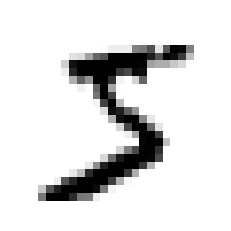

In [16]:
# Plot an image

number = data[0,:].reshape(28, 28)

plt.imshow(number, mpl.cm.binary)
plt.axis("off")
plt.show()

## **Create Train and Test groups using DataLoader**

In [17]:
# Convert data and labels to pytorch tensors
dataT = torch.tensor(data).float()
targT = torch.tensor(targets.astype(int)).long()

In [18]:
# Split the data into train and test sets
from sklearn.model_selection import StratifiedShuffleSplit
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
for train_index, test_index in ss_split.split(dataT, targT):
  X_train, X_test, y_train, y_test = dataT[train_index, :], dataT[test_index, :], targT[train_index], targT[test_index] 

In [19]:
# Convert to Pytorch Datasets
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [20]:
# Translate into dataloader objects
batchsize = 128
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## **Create a Feed Forward Network**

In [21]:
# Define an abstract base class for curiosity
from abc import ABC, abstractmethod

class BaseCuriosity(ABC):
  """
  Abstract Base Class to ensure consistent interface across all concrete classes.
  All concrete classes should implement `curiosity` method.
  """
  def __init__(self, mode='standard'):
    self.mode = mode

  @abstractmethod
  def curiosity(self):
    pass

In [22]:
class CuriousFFN(nn.Module, BaseCuriosity):
  """
  Defines model architecture and curiosity in the context of MNIST image classfication.

  Parameters:
  -----------
  mode : str, (default: 'standard')
    - If 'standard', calls forward method, the model behaves like a normal FFN.
    - If 'curious', calls curiosity method, the model incorporates artificial curiosity while predicting class of input image.

  Note:
  -----
  While training use 'standard' mode and while predicting use any of the two.
  """
    
  # Initialize mode, input layer, hidden layers, output layer and their number of units respectively.
  def __init__(self, mode='standard') -> None:
    super().__init__()
    self.mode = mode

    # input layer
    self.input = nn.Linear(784, 64)

    # hidden layers
    self.hidden1 = nn.Linear(64, 64)
    self.hidden2 = nn.Linear(64, 64)

    # output layer
    self.output = nn.Linear(64, 10)

  # Customize nn.Module's __call__ method to change behaviour of the model.
  def __call__(self, inp):
    if self.mode == 'standard':
      return self.forward(inp)
    elif self.mode == 'curious':
      return self.curiosity(inp)
    else:
      raise ValueError(f"Invalid mode '{self.mode}'")

  # Forward pass
  def forward(self, X):
    X = F.relu(self.input(X))
    X = F.relu(self.hidden1(X))
    X = F.relu(self.hidden2(X))
    # return raw output
    return torch.log_softmax(self.output(X), axis=1)

  # Artificial Curiosity
  def curiosity(self, img_data):
    """
    Incorporates artificial curiosity while predicting class of input images.

    Parameters:
    -----------
    img_data: arraylike
      - The input image data, preferrably as a pytorch tensor.

    Returns:
    --------
    prediction: tensor
      - The predicted class of the input image.

    Notes:
    -----
    "Artificial curiosity in the context of the project is a process that involves applying affine transformations to input data and using a model to predict on the transformed data. The model then filters the predictions based on the least entropy for log-softmax values, specifically softmax values. In this project, the model explores different orientations and flips of the input data to identify patterns and enhance its performance. While the number and types of transformations used in this project are limited for demonstration purposes, the concept of artificial curiosity can be extended to include a range of creative transformations.
    This project uses a feed-forward neural network (FFN) because FFNs lack spatial perception and are unable to recognize images that do not resemble the training data. This weakness of FFNs is exploited to demonstrate the concept of artificial curiosity. When the model is predicting with 'curious' mode, it can recognize manipulated images, while in 'standard' mode, it cannot. This distinction provides a clear demonstration of the advantages and limitations of the two modes.
    Affine transformations are a type of transformation that preserves parallel lines, angles, and distances in an image. Log-softmax values are the logarithm of the softmax function, which converts the output of a neural network into a probability distribution over the possible classes. By using the least entropy for log-softmax values, the model can make more confident predictions.
    Overall, this project demonstrates how artificial curiosity can be used to improve a model's performance by exploring and adapting to novel input data, even if the data has been manipulated. ". 
    """

    # 1. Convert image data to numpy array if not already.
    if type(img_data) != 'numpy.ndarray':
        img_data = np.array(img_data.reshape(28,28).detach())
    img = img_data.copy()

    # 4. Repeat steps 2 and 3 for a certain number of iterations.
    softmax_tensors = []
    entropies = []
    for flip in range(2):
      for azimuth in range(0,360,45):

        # 2. Apply transformation.
        rows, cols = img.shape[:2]
        center = (cols/2, rows/2)
        rotation_matrix = cv2.getRotationMatrix2D(center, azimuth, 1)
        rotated_image = cv2.warpAffine(img, rotation_matrix,  (cols, rows))
        rotated_image = torch.tensor(rotated_image).reshape(1, -1)

        # 3. Forward pass
        logsoftmax_pred = self.forward(rotated_image)

        # 5. Convert log-softmax tensor to softmax tensor.
        softmax_pred = torch.exp(logsoftmax_pred)

        # 6. Store softmax tensor.
        softmax_tensors.append(softmax_pred)

        # 7. Calculate entropy for softmax tensor.
        cat_dist = torch.distributions.Categorical(softmax_pred.detach().reshape(-1))
        entropy = cat_dist.entropy()
        entropies.append(entropy)

        # Temporary print statements
        print(f"Flip: {flip}\n Azimuth: {azimuth} deg\n Softmax: {softmax_pred.detach().reshape(-1)}\n Entropy: {entropy}")

        fig, ax = plt.subplots(1, 2, figsize=(12,6))
        ax[0].imshow(rotated_image.reshape(28, 28), mpl.cm.binary)
        ax[0].axis("off")

        ax[1].bar(np.arange(0,10), softmax_pred.detach().reshape(-1).numpy())
        ax[1].set_xticks(np.arange(0,10,1))
        ax[1].set_xlabel('numbers')
        ax[1].set_ylabel('probability')
        plt.show()
        plt.pause(0.1)
        print(' \n ')

      # 8. Mirror the original image data before proceeding for next iteration of outer loop.
      img = cv2.flip(img_data, 0)

    # 9. Return the instance with lowest entropy value as prediction.
    min_idx = entropies.index(min(entropies))
    prediction = torch.argmax(softmax_tensors[min_idx])

    return prediction 


In [23]:
def createCuriousFFN():
  # Model instance
  net = CuriousFFN(mode='standard')
  
  # Loss funtion
  lossfun = nn.NLLLoss()

  # Optimizer
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

  return net, lossfun, optimizer


In [24]:
def trainCuriousFFN(net, lossfun, optimizer):
  """
  A function to train an FFN model.
  """
  # Set number of iterations for training
  numepochs = 20

  # Initialize losses and accuracies
  losses = torch.zeros(numepochs)
  train_acc = []
  test_acc = []

  # Loop over numepochs
  for epoch in range(numepochs):

    # Initialize batch losses and accuracies
    batch_loss = []
    batch_acc = []

    # Loop over minibatches from train_loader
    for X, y in train_loader:

      # Forward prop
      yHat = net(X)

      # Loss function
      loss = lossfun(yHat, y)

      # Back prop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute and store losses from this batch
      batch_loss.append(loss.item())

      # Compute and store accuracies
      batch_acc.append(torch.mean((torch.argmax(yHat,axis=1) == y).float())*100)
        
    # Compute and store average loss across batches
    losses[epoch] = np.mean(batch_loss)

    # Compute and store average training acuracy
    train_acc.append(np.mean(batch_acc))

    # Test accuracy
    X, y = next(iter(test_loader))
    with torch.no_grad():
        yHat = net(X)

    # Compute and store test accuracy
    test_acc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float())*100)

  return net, losses, train_acc, test_acc

In [25]:
# Create a model
ffn, lossf, optim = createCuriousFFN()

# Train the model
ffn, losses, train_acc, test_acc = trainCuriousFFN(net=ffn, lossfun=lossf, optimizer=optim)

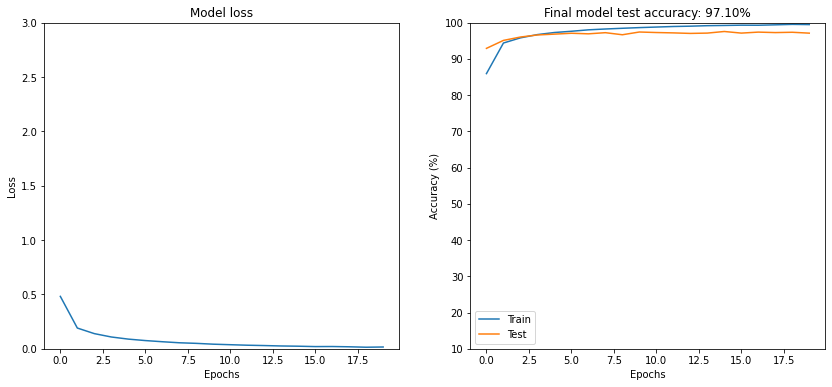

In [26]:
# Visualize the performance
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(train_acc,label='Train')
ax[1].plot(test_acc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}%')
ax[1].legend()

plt.show()

## **Testing Curiosity of the model**

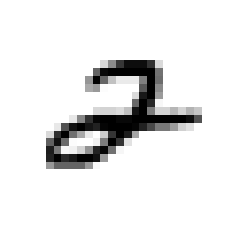

tensor(2)


In [54]:
sample_image= next(iter(test_loader))[0][60].reshape(28, 28)
sample_label = next(iter(test_loader))[1][60]

plt.imshow(sample_image, mpl.cm.binary)
plt.axis("off")
plt.show()

print(sample_label)

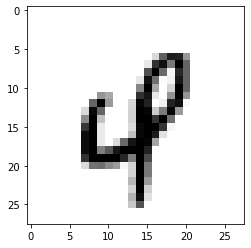

In [55]:
# Manipulate test image before feeding it to the trained model for prediction.
sample_image = np.array(sample_image.detach())
sample_image = cv2.flip(sample_image, 1) 
rows, cols = sample_image.shape[:2]
center = (cols/2, rows/2)
angle = 90
angle_rad = angle * np.pi / 180
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
rotated_image = cv2.warpAffine(sample_image, rotation_matrix,  (cols, rows))
sample_image = torch.tensor(rotated_image.reshape(1, -1))
plt.imshow(rotated_image, mpl.cm.binary)
plt.show()
# The image is flipped and rotated by 90 degrees, let's see if the trained FFN is able to recognize the digit using its curiosity.

In [56]:
ffn.mode = 'standard'
output = ffn(sample_image)
output

tensor([[ -8.6302, -12.6633,  -8.2682,  -2.9747, -10.3361,  -4.0508,  -6.4831,
         -10.8272,  -0.2615,  -1.8351]], grad_fn=<LogSoftmaxBackward0>)

In [57]:
torch.argmax(output, axis=1)

tensor([8])

With 'standard' mode the model predicts that the input image is '8'. Let's see what happens with the 'curious' mode.

Flip: 0
 Azimuth: 0 deg
 Softmax: tensor([1.7863e-04, 3.1653e-06, 2.5656e-04, 5.1063e-02, 3.2442e-05, 1.7409e-02,
        1.5291e-03, 1.9852e-05, 7.6991e-01, 1.5960e-01])
 Entropy: 0.7307760715484619


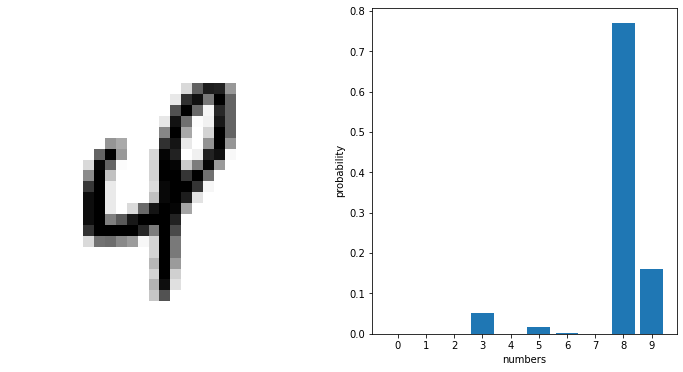

 
 
Flip: 0
 Azimuth: 45 deg
 Softmax: tensor([6.2607e-07, 4.0653e-03, 4.1988e-01, 1.1627e-03, 1.3134e-05, 3.6276e-06,
        1.5620e-05, 1.2891e-05, 5.7454e-01, 3.0823e-04])
 Entropy: 0.7160171270370483


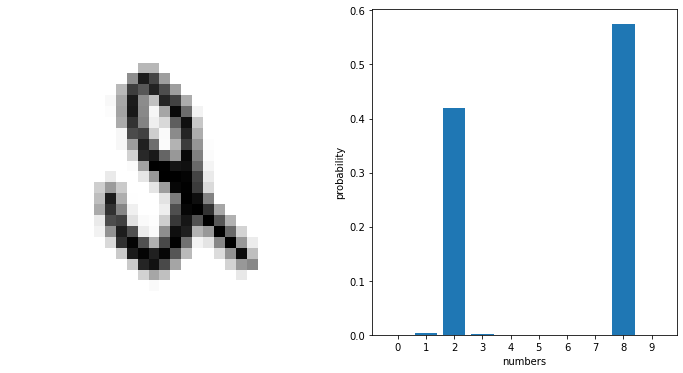

 
 
Flip: 0
 Azimuth: 90 deg
 Softmax: tensor([9.5916e-05, 3.5493e-06, 3.4427e-02, 3.8575e-01, 2.2467e-09, 2.7102e-05,
        2.3082e-03, 6.6209e-03, 5.7076e-01, 9.6052e-08])
 Entropy: 0.8519595265388489


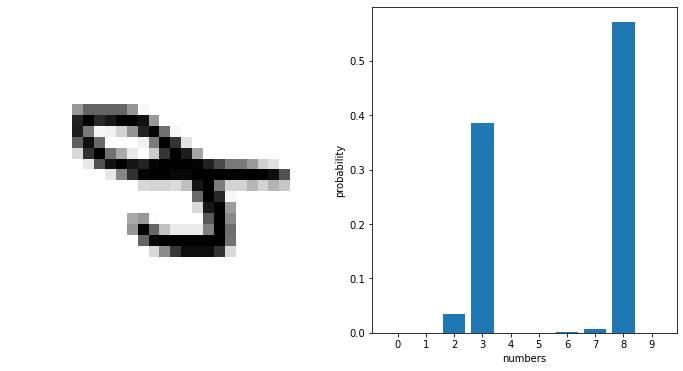

 
 
Flip: 0
 Azimuth: 135 deg
 Softmax: tensor([3.3609e-05, 5.0499e-04, 9.8762e-01, 9.6194e-04, 1.0307e-02, 4.8814e-06,
        2.0807e-06, 4.6595e-04, 9.9150e-05, 4.1933e-09])
 Entropy: 0.0748944878578186


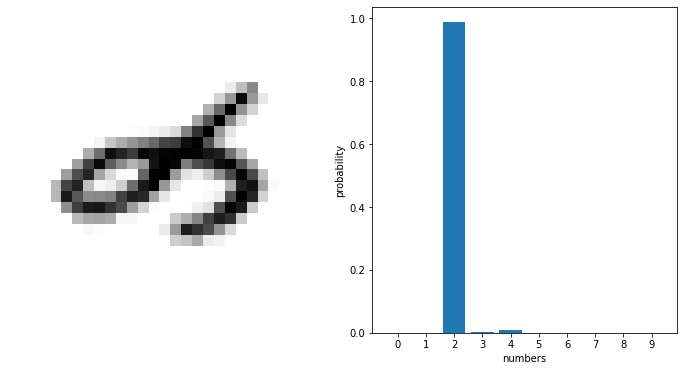

 
 
Flip: 0
 Azimuth: 180 deg
 Softmax: tensor([3.1016e-02, 5.1745e-06, 6.4716e-05, 5.6585e-05, 1.3354e-06, 9.6978e-03,
        1.4189e-02, 1.6447e-05, 9.4494e-01, 1.1675e-05])
 Entropy: 0.26814767718315125


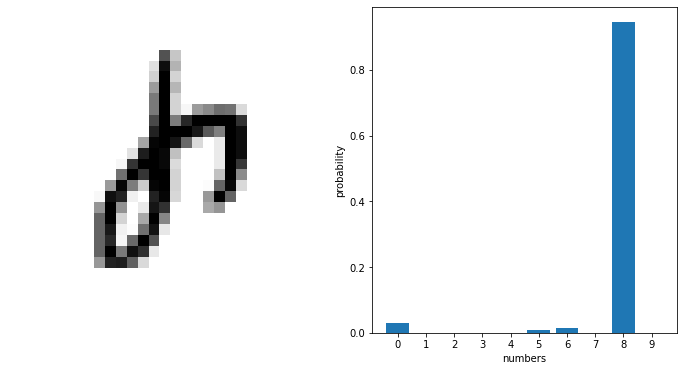

 
 
Flip: 0
 Azimuth: 225 deg
 Softmax: tensor([9.2533e-07, 1.2845e-10, 7.6462e-06, 7.0287e-05, 5.1971e-10, 1.9198e-06,
        6.3653e-08, 1.6331e-09, 9.9992e-01, 1.7742e-07])
 Entropy: 0.0008851687889546156


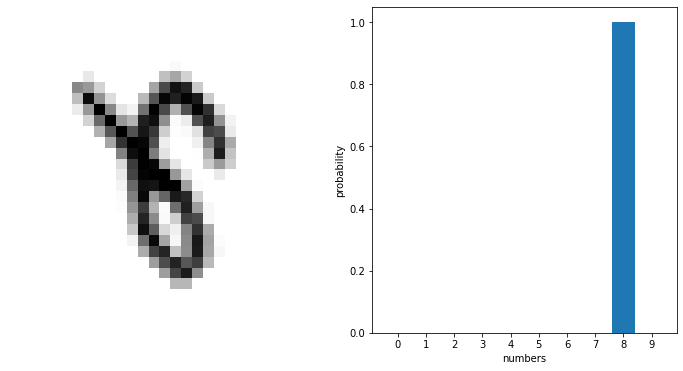

 
 
Flip: 0
 Azimuth: 270 deg
 Softmax: tensor([2.3298e-06, 4.0855e-05, 5.6569e-02, 1.7893e-01, 7.0979e-01, 5.1356e-02,
        4.7348e-07, 2.0945e-05, 8.8332e-04, 2.4073e-03])
 Entropy: 0.8875600099563599


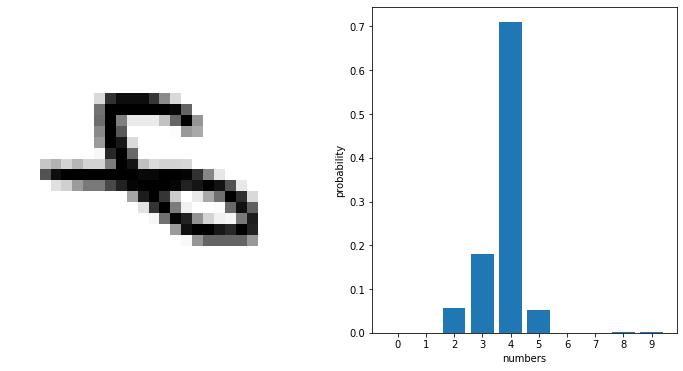

 
 
Flip: 0
 Azimuth: 315 deg
 Softmax: tensor([6.6157e-05, 6.5291e-06, 4.7655e-02, 4.5315e-06, 2.3605e-03, 2.3491e-06,
        9.4682e-01, 2.7736e-08, 3.0845e-03, 5.6164e-07])
 Entropy: 0.22971150279045105


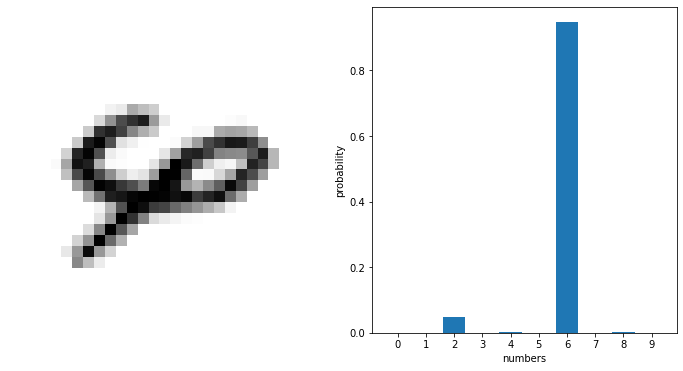

 
 
Flip: 1
 Azimuth: 0 deg
 Softmax: tensor([5.7911e-06, 2.2782e-02, 6.1661e-02, 6.1677e-02, 7.5944e-05, 1.8946e-05,
        1.1425e-05, 1.2858e-01, 7.1609e-01, 9.0923e-03])
 Entropy: 0.9765174388885498


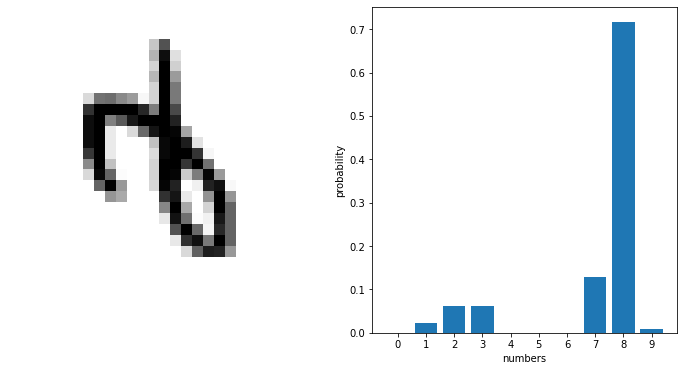

 
 
Flip: 1
 Azimuth: 45 deg
 Softmax: tensor([6.3570e-05, 1.4791e-03, 4.0171e-04, 3.3001e-03, 4.4315e-06, 8.9801e-03,
        4.9910e-02, 9.3523e-01, 6.3239e-04, 7.0343e-09])
 Entropy: 0.29151827096939087


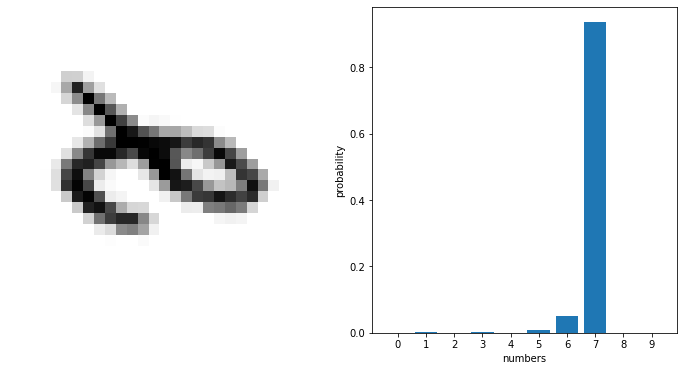

 
 
Flip: 1
 Azimuth: 90 deg
 Softmax: tensor([8.5384e-04, 2.6729e-08, 9.9905e-01, 2.3473e-05, 1.2384e-08, 1.1529e-07,
        1.3338e-06, 2.4976e-05, 4.1858e-05, 8.3008e-14])
 Entropy: 0.007935585454106331


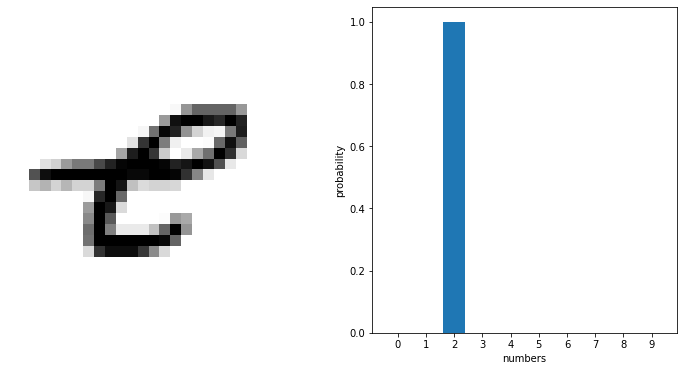

 
 
Flip: 1
 Azimuth: 135 deg
 Softmax: tensor([8.1850e-02, 8.3337e-04, 3.2078e-03, 4.6734e-05, 1.0416e-05, 1.6351e-03,
        3.1747e-01, 1.1112e-06, 5.9494e-01, 8.2796e-08])
 Entropy: 0.9134876728057861


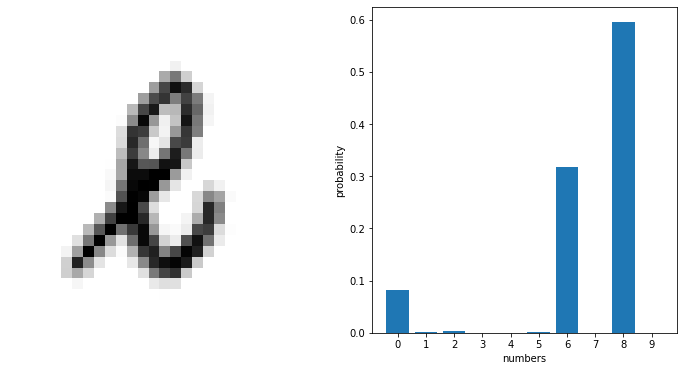

 
 
Flip: 1
 Azimuth: 180 deg
 Softmax: tensor([3.4120e-10, 9.0387e-06, 8.5607e-07, 8.9480e-01, 8.9957e-08, 3.0347e-02,
        5.2198e-07, 8.4598e-07, 7.4814e-02, 3.0812e-05])
 Entropy: 0.39996039867401123


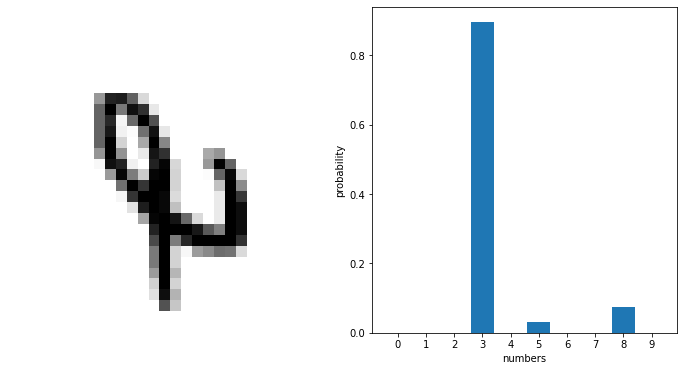

 
 
Flip: 1
 Azimuth: 225 deg
 Softmax: tensor([3.1210e-04, 2.8799e-07, 1.9324e-02, 7.5606e-08, 7.6716e-01, 9.9116e-06,
        2.1319e-01, 5.2072e-10, 4.4156e-06, 2.2045e-08])
 Entropy: 0.6117982864379883


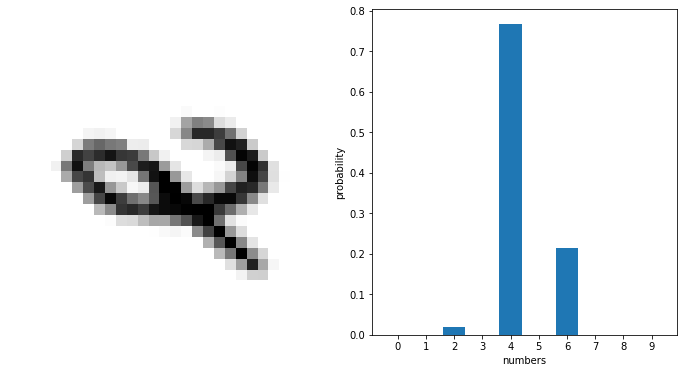

 
 
Flip: 1
 Azimuth: 270 deg
 Softmax: tensor([2.0115e-06, 6.8599e-10, 9.9998e-01, 5.1893e-06, 3.7229e-10, 2.6933e-12,
        1.6706e-09, 7.8972e-06, 4.4938e-07, 1.6579e-13])
 Entropy: 0.00020442504319362342


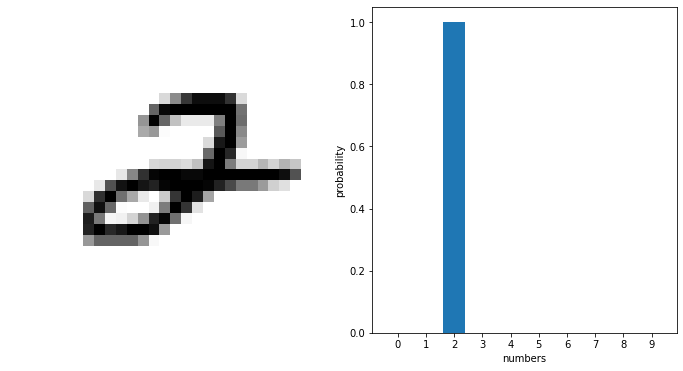

 
 
Flip: 1
 Azimuth: 315 deg
 Softmax: tensor([2.0496e-07, 3.6290e-06, 4.9484e-05, 7.5017e-03, 1.0615e-08, 4.8594e-08,
        3.1000e-11, 6.4354e-04, 9.9147e-01, 3.2632e-04])
 Entropy: 0.05308050662279129


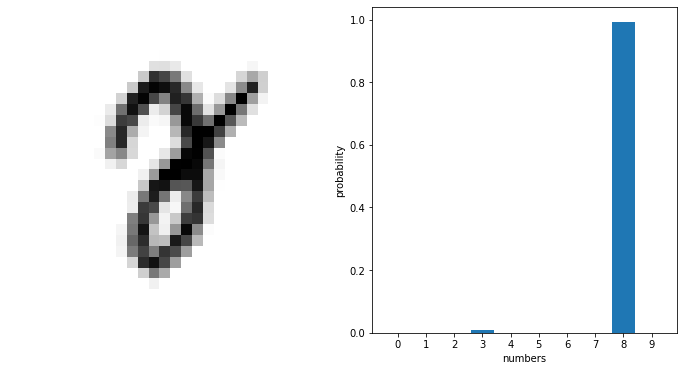

tensor(2)

In [58]:
ffn.mode = 'curious'
output = ffn(sample_image)
output

As seen above, in the last line of the output, the model predicts the input image to be `tensor(2)`. This demonstrates a Feed Forward Network that is known to not have spatial perception and trained on non-manipulated images is able to recognize manipulated images using it's curiosity. The Artificial Curiosity here includes limited types and number of transformations for demonstration purpose. 